<div>
    <h1 style="margin-top: 50px; font-size: 33px; text-align: center">Homework 4 - Does basic house information reflect house descriptions?</h1>
    <br>
    <div style="font-weight:200; font-size: 20px; padding-bottom: 15px; width: 100%; text-align: center;">
        <right>Davide Toma, Giacomo Lo Cascio, Musie </right>
        <br>
    </div>
    <hr>
</div>

First of all we import all the libraries we need and we have to initialize the empty dataframe.

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import time
import math
import pickle
import numpy as np

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#import num2words

from wordcloud import WordCloud,STOPWORDS
from PIL import Image
from string import punctuation


In [2]:
df = pd.DataFrame(columns=["Title", "Price","Locali","Superficie","Bagni","Piano","Description"])
address =  "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="
page = "https://www.immobiliare.it/"

Now we have to fill the empty dataframe by doing web scraping and using the library BeautifulSoup. The website we have to scrape is www.immobiliare.it , a website where houses are sold.

In [4]:
count=0
row=0
for i in range(1,651):
    address = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="+str(i)
    url = requests.get(address)
    page =BeautifulSoup(url.text, 'lxml') 
    x = page.findAll('ul',{'class','annunci-list'})[0]
    
    types = ["vetrina","star","top","premium"]
    
    for t in types:
        
        for y in x.find_all('li', {'class', 'listing-item '+t+' js-row-detail'}):
            try:
                content = y.find('div',class_='listing-item_body--content')
                title = content.p.a.attrs
                if title['href'][:5]=="https":
                    site= title["href"]
                else:
                    site = 'https://www.immobiliare.it' + title['href']
                url2 = requests.get(site)
                page2 = BeautifulSoup(url2.text, 'lxml')
                descr = page2.find('div',class_='col-xs-12 description-text text-compressed')
                description = descr.div.text.strip()
                price = content.find('li', class_='lif__item lif__pricing').text
                locali_superficie = content.find_all(class_= 'text-bold')
                locali = locali_superficie[0].text
                superficie = locali_superficie[1].text
                bagni = locali_superficie[2].text
                piano = locali_superficie[3].text.strip()
                if len(piano)>3:
                    raise
                
                df.loc[row] = [title['title'],price.strip(),locali,superficie,bagni,piano,description]
                row+=1

            except:
                #print("Not considering a column")
                count+=1


We write a .csv file to have the dataframe without rerunning every time the code of the web scraping.

In [7]:
df.to_csv("dataset.csv")

In [12]:
print(row)
df.head()

12453


,Title,Price,Locali,Superficie,Bagni,Piano,Description
0,"Bilocale viale Italo Calvino, Fonte Ostiense, ...",€ 225.000,2,50,1,1,PAPILLO EUR in elegante complesso residenziale...
1,"Bilocale via Ezio Sciamanna 12, Torrevecchia, ...",€ 159.000€ 169.000(-5.9%),2,65,1,R,Rif: 18083 - TORREVECCHIA - Via Ezio Sciamanna...
2,"Attico / Mansarda via Taranto 100, San Giovann...",€ 459.000,2,85,1,A,"San Giovanni, Attico in Vendita, via Taranto l..."
3,"Attico / Mansarda via Degli Orti Di Galba, Mon...",€ 850.000,5,175,2,A,"Nel quartiere Monteverde, a poche decine di me..."
4,"Appartamento via San Sotero, Gregorio VII - Pi...",€ 1.100.000,5+,225,3+,3,Gregorio Settimo - San Damaso \nNelle immediat...


# PART-1: CLUSTERING

Now we work loading the csv file.

We consider only 10000 rows, to make sure that every process does not take too much time, as the task involved obtaining at least 10,000 documents from web scraping (we have obtained more than 12,000), but to work from this point on, we can consider exactly 10,000 lines of the data frame.

Let's take a look to the dataframe.

In [13]:
df = pd.read_csv('dataset.csv')

In [14]:
df = df[:10000]
df

,Unnamed: 0,Title,Price,Locali,Superficie,Bagni,Piano,Description
0,0,"Bilocale viale Italo Calvino, Fonte Ostiense, ...",€ 225.000,2,50.0,1,1,PAPILLO EUR in elegante complesso residenziale...
1,1,"Bilocale via Ezio Sciamanna 12, Torrevecchia, ...",€ 159.000€ 169.000(-5.9%),2,65.0,1,R,Rif: 18083 - TORREVECCHIA - Via Ezio Sciamanna...
2,2,"Attico / Mansarda via Taranto 100, San Giovann...",€ 459.000,2,85.0,1,A,"San Giovanni, Attico in Vendita, via Taranto l..."
3,3,"Attico / Mansarda via Degli Orti Di Galba, Mon...",€ 850.000,5,175.0,2,A,"Nel quartiere Monteverde, a poche decine di me..."
4,4,"Appartamento via San Sotero, Gregorio VII - Pi...",€ 1.100.000,5+,225.0,3+,3,Gregorio Settimo - San Damaso \r\nNelle immedi...
5,5,"Trilocale via Raffaele De Ferrari 60, Borghesi...",€ 119.000€ 129.000(-7.8%),3,85.0,1,2,Rif: 18094 - CASILINA - Via Raffaele De Ferrar...
6,6,"Trilocale via delle Palme 16, Centocelle, Roma",€ 149.000,3,75.0,1,1,Rif: 18067 - CENTOCELLE - Via delle Palme. Nel...
7,7,"Attico / Mansarda piazzale Clodio, 12, Mazzini...",€ 1.300.000,4,115.0,2,9,PIAZZALE CLODIO \r\nSiamo a proporvi uno splen...
8,8,"Bilocale via Silicella 17, Tor Tre Teste - Tor...",€ 115.000,2,58.0,1,3,Rif: 18028 - TORRE MAURA - Via Silicella. Nell...
9,9,"Appartamento via Edoardo Jenner 163, Colli Por...",€ 695.000,5+,250.0,3,3,"Nel quartiere di Monteverde Nuovo, più precisa..."


### CLEANING THE DATASET

Now we have to clean the dataset, and we clean it as follows:

1) We drop the columns we don't need for the matrices.

2) We replace the €,+,. symbols in every column.

3) We drop every row with 'Piano' values that are not digit.

4) We drop every row with 'Price' values that are longer than 7, because we can't find an house with 10000000€ of price in Rome

5) We drop all the Nan values

In [15]:
df1 = df.drop(columns = ['Unnamed: 0','Title'])

df1 = df1.replace('€','', regex = True)

df1 = df1[df1['Piano'].apply(lambda x: str(x).isdigit())]

df1['Price'] = list(map(lambda x: x.replace('.',''),df1['Price']))
df1['Locali'] = list(map(lambda x: x.replace('+',''),df1['Locali']))
df1['Bagni'] = list(map(lambda x: x.replace('+',''),df1['Bagni']))

df1 = df1[df1['Price'].apply(lambda x: len(str(x)) <= 7)]

### MATRIX 1

Now we consider the dataframe without the descriprion column, and we build the first matrix.

In [16]:
df2 = df1.drop(columns = ['Description'])

df2.dropna()

,Price,Locali,Superficie,Bagni,Piano
0,225000,2,50.0,1,1
6,149000,3,75.0,1,1
8,115000,2,58.0,1,3
9,695000,5,250.0,3,3
12,370000,4,139.0,2,5
13,359000,4,130.0,3,3
14,650000,5,170.0,3,1
15,800000,5,220.0,3,4
16,650000,5,193.0,3,4
17,339000,2,70.0,1,3


In the next two cells we convert the dataframe in a matrix, because the homework said we have to work with matrices.

In [17]:
col = ['Price','Locali','Superficie','Bagni','Piano']
m = df2.as_matrix(columns = col)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [18]:
mat = np.matrix(m).astype(float)
mat

matrix([[2.25e+05, 2.00e+00, 5.00e+01, 1.00e+00, 1.00e+00],
        [1.49e+05, 3.00e+00, 7.50e+01, 1.00e+00, 1.00e+00],
        [1.15e+05, 2.00e+00, 5.80e+01, 1.00e+00, 3.00e+00],
        ...,
        [6.80e+04, 1.00e+00, 2.00e+01, 1.00e+00, 4.00e+00],
        [8.39e+05, 4.00e+00, 1.70e+02, 2.00e+00, 2.00e+00],
        [5.20e+05, 3.00e+00, 8.60e+01, 1.00e+00, 1.00e+00]])

Now we implement the Elbow method by using the sklearn library to find the better k (k is number of clusters).
The Elbow method is a method of interpretation and validation of consistency within cluster analysis designed to help finding the appropriate number of clusters in a dataset.

We have to choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. When we plot the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion".

Since this is a visual method, so we need to visualize the curve to find the better number of clusters.

Text(0.5,1,'Elbow Curve')

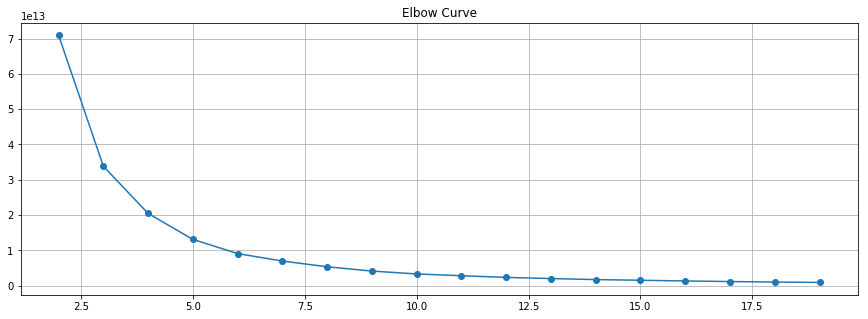

In [19]:
sse = []
for k in range (2,20):
    kmeans = KMeans(n_clusters=k, random_state = 0).fit(mat)
    sse.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(15,5))
plt.plot(range(2,20), sse, marker = 'o')
plt.grid(True)
plt.title('Elbow Curve')

Now we will have the array (with lenght the number of rows of the matrix) and each element of the array will have the number of the cluster to which it belongs.
We define also a function that count the number of occurences and then it will give the dictionary with the cluster as key and the number of records belonging to this cluster as value.

In [20]:
kmeans = KMeans(n_clusters=4, random_state = 0).fit(mat)
arr = kmeans.labels_

In [21]:
def clusval(arr):
    
    d = {}
    for i in range(len(arr)):
        if arr[i] not in d:
            d[arr[i]] = 1
        else:
            d[arr[i]] = d[arr[i]] + 1
    return d


clusval(arr)
    

{2: 2544, 1: 689, 0: 1958, 3: 1168}

In [22]:
arr

array([2, 2, 2, ..., 2, 1, 3])

At this point, to make the wordcloud using the clusters, we need to save in a dictionary, for each key (keys are the clusters), 
the index of the row of the dataframe belonging to that cluster.

In [23]:
d1={}
for idx,i in enumerate(arr):
    d1.setdefault(i, []).append(idx)
#dictionary with keys the clusters' names, and values the lits of the indices of the announcements in that cluster

### MATRIX 2

Now we have to build the second matrix, and we have to consider the "Description" column of the clean dataframe.

In [24]:
desc = df1['Description']
leng = len(desc)
print(leng)
print(len(desc.dropna()))

6359
6359


We see that there are no Nan values in the description.

Now let's do some preprocessing.

To preprocess the data in this case, we built some functions:

1) The first function removes stopwords from the italian language.

2) The second function removes punctuation from list of tokenized words.

3) The third function stems words in a list of tokenized words.

4) The fourth function converts all characters to lowercase from a list of tokenized words.

5) The fifth function replaces all integers occurences in list of tokenized words with textual representation.

In the end, we create a function that recall all the previous function and therefore preprocessed the data.

In [25]:
def remove_stopwords(wrd):
    new_wrd = [] #List of updated words
    
    for word in wrd:
        if word not in stopwords.words('italian'): # If the current word is not a stopword (ckeck using nltk)
            new_wrd.append(word)                   #appends it to the list
  
    return new_wrd


def remove_punctuation(wrd):
    new_wrds = []  #List of updated words
    
    for word in wrd:
        new_wrd = re.sub(r'[^\w\s]', '', word) # Replaces all punctuation word with "" using RegEx
        if new_wrd != '':
            new_wrds.append(new_wrd)           #And then appends all words different from "" to the list 
    
    return new_wrds


def stem_words(wrd):
    stemmer = SnowballStemmer('italian') # Selects the stemmmer from nltk
    stems = [] # List of updated words
    
    for word in wrd:
        stem = stemmer.stem(word) # Stems the word
        stems.append(stem)        # and appends it to the list
        
    return stems



def to_lowercase(wrd):
    new_wrds = [] # List of updated words
    
    for word in wrd:
        new_wrd = word.lower()   # Converts the current word to lower case
        new_wrds.append(new_wrd) # And append it to the list
        
    return new_wrds




def replace_numbers(wrd):
    
    new_wrds = [] # List of updated words

    for word in wrd:
        if word.isdigit(): # If the current word is a number
            new_wrd = num2words.num2words(int(word),lang='it') # Converts it to its textual representation
            new_wrds.append(new_wrd) # And appends it to the list
        else:
            new_wrds.append(word) # If the current word is not a number appends it to the list
            
    return new_wrds



def preProcessing (x):
    #x.fillna("*", inplace = True) # fills NA with "*"
    #if xt != "*":
        
    xt = nltk.word_tokenize(x) # Tokenizes query using nltk
    
    # Uses previous functions    
    xt = replace_numbers(xt)
    xt = remove_stopwords(xt)
    xt = remove_punctuation(xt)
    xt = stem_words(xt)
    xt = to_lowercase(xt)
   
    return xt

In [47]:
pdesc = desc.apply(preProcessing)

In [48]:
pdesc.head()

0     [papill, eur, eleg, compless, residenzial, rif...
6     [rif, diciottomilasessantasett, centocell, via...
8     [rif, diciottomilaventott, torr, maur, via, si...
9     [nel, quart, monteverd, nuov, precis, via, edo...
12    [in, zon, cinecitt, est, propon, vend, appart,...
Name: Description, dtype: object

Now we can create a vocabulary as in the previous homework, which associates for each word an id with and the number of documents in which it appears.

In [50]:
def create_vocabulary(pdesc):
    vocabulary = {} # The vocabulary is a dictionary of the form "Word : (word_id,numberofdocs)"
    inverted_index= {}
    wid = 0 # word_id
    for line in pdesc: 
        for word in set(line):
            if not word in list(vocabulary.keys()) : # if the word is not in the dic
                vocabulary[word] = (wid,1) # adds it
                wid += 1 # Update word_id
            else:
                a, b = vocabulary[word]
                vocabulary[word] = (a,b+1)
    return vocabulary

In [51]:
voc = create_vocabulary(pdesc)

Let's see an example and the numner of words we have

In [65]:
print(len(voc))
voc['angol']

18644


(1, 1257)

Now the next step is to create the IDFi function and then to create the second matrix.

In [18]:
def IDFi(term):
    return math.log10(leng/voc[term][1])

In [20]:
idfi = []
for term in voc:
    idfi.append(IDFi(term)) 

In [60]:
idfi[:5]

[2.0630261354893698,
 0.7040535472976557,
 2.039960831420676,
 1.9838448894417449,
 1.3640561311533508]

Here we finally build the second matrix. We normalize the idfi and append the tfidf in the second matrix, as requested.

In [60]:
nwords= len(voc)
mat2=np.zeros((leng,nwords))
for idx,line in enumerate(pdesc):
    for word in set(line):
        wid = voc[word][0]
        tfidf = line.count(word)/len(line)*idfi[wid]
        mat2[idx,wid] = tfidf

In [62]:
'''with open('matrix2', 'wb') as f:
    x = pickle.dump(mat2,f)'''

Now we can reload the matrix without run:

In [48]:
with open('matrix2', 'rb') as f:
    mat2 = pickle.load(f)

In [49]:
mat2.shape

(6359, 18644)

Now let's reapply the Elbow method, as done for the first matrix, for the second one but we have a lot of columns in this case.

Text(0.5,1,'Elbow Curve')

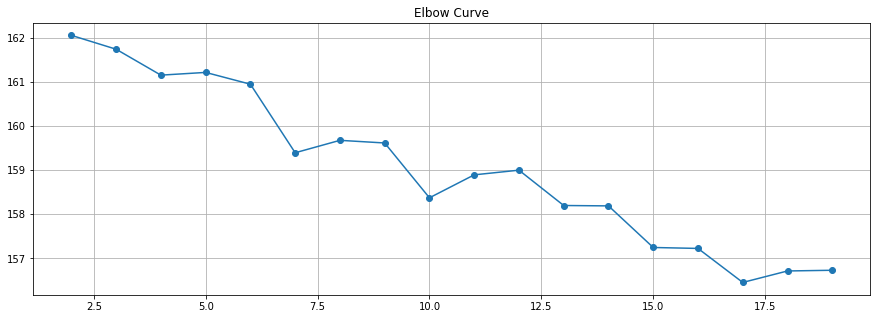

In [23]:
sse2 =[]
for k in range (2,20):
    kmeans2 = KMeans(n_clusters=k, random_state = 0).fit(mat2)
    sse2.append(kmeans2.inertia_)
    
fig = plt.figure(figsize=(15,5))
plt.plot(range(2,20), sse2, marker = 'o')
plt.grid(True)
plt.title('Elbow Curve')

As we expected, the method for this matrix should be applied by iterating the number of clusters (k), for numbers much larger than k.
In fact, as we can see, the curve does not follow the trend shown for the first matrix and we can not see for what k it tends to 0 from the graph that we plotted.

Probably the optimal number of clusters in this case would have been about a thousand, but it would make absolutely no sense to consider a thousand clusters for a dataframe of just over 6000 lines (besides being senseless it is also extremely slow as a process).

To better compare the results on the clusters of the two matrices, let's consider also for this matrix the same number as the first one, then k = 4.

In [50]:
kmeans2 = KMeans(n_clusters=4, random_state = 0).fit(mat2)
arr2 = kmeans2.labels_

In [51]:
clusval(arr2) 

{3: 5056, 2: 1218, 1: 54, 0: 31}

As we did for the first matrix clusters, now we build a dictionary where the keys are the second matrix clusters names and the values are the announcements that belong to that cluster.

In [52]:
d2={}
for idx,i in enumerate(arr2):
    d2.setdefault(i, []).append(idx)
#dictionary with keys the clusters' names, and values the lits of the indices of the announcements in that cluster

## WORDCLOUD

First of all, let's explain what is a word cloud:

Word clouds (also known as text clouds or tag clouds) work in a simple way: the more a specific word appears in a source of textual data (such as a speech, blog post, or database), the bigger and bolder it appears in the word cloud.

In the right setting, word cloud visualizations are a powerful tool. Here are a few instances when word clouds excel:

1) Finding customer pain points — and opportunities to connect. Do you collect feedback from your customers? (You should!) Analyzing your customer feedback can allow you to see what your customers like most about your business and what they like least. Pain points (such as “wait time,” “price,” or “convenience”) are very easy to identify with text clouds.

2) Understanding how your employees feel about your company. Text cloud visualization can turn employee feedback from a pile of information you’ll read through later to an immediately valuable company feedback that positively drives company culture.

3) Identifying new SEO terms to target. In addition to normal keyword research techniques, using a word cloud may make you aware of potential keywords to target that your site content already uses.

Now it's time to do wordclouds!

Here we compute the Jaccard similarity between the first clusters and the second ones.

The Jaccard coefficient measures the similarity between sample sets, and is defined as the dimension of the intersection divided by the size of the union of the sample sets.

So we implement the Jaccard similarity between our clusters and choose the three pairs of clusters that have a higher similarity.

In [53]:
similarity = np.zeros((4,4))
for i in range (4):
    for j in range(4):
        Si = set(d1[i])
        Sj = set(d2[j])
        sim = (len(Si.intersection(Sj))/len(Si.union(Sj)))
        similarity[i,j] = sim
        similarity[j,i] = sim
similarity

array([[0.00201511, 0.        , 0.00940808, 0.00250836],
       [0.        , 0.00405405, 0.0073672 , 0.00741962],
       [0.00940808, 0.0073672 , 0.18975332, 0.08652095],
       [0.00250836, 0.00741962, 0.08652095, 0.18372005]])

We took the top three most similar couples of clusters we will use to make wordclouds.

In [54]:
similarity2 = similarity
couples = []
for i in range (3):
    maxx = np.unravel_index(np.argmax(similarity2), similarity2.shape)
    couples.append(maxx)
    similarity2[maxx] = 0

couples

[(2, 2), (3, 3), (2, 3)]

### First couple

Now we have to make Wordclouds with the three couples of cluster we have from the previous task.

The words that will be represented are those extracted from the description of the houses that are in the relative couple, so we have to make an intersection between the couple of cluster (to find the documents in common between the two clusters), then extract all the description of these documents and we use the wordcloud library to visualize these words.

In [55]:
a = set(d1[2])
b = set(d2[2])

intersect1 = list(a.intersection(b))

In [56]:
text1 =''
for i in range(len(intersect1)):
    text1 = text1 + df.iloc[intersect1[i]]['Description']

Now we define a function that eliminate the punctuation in the text we obtained.

In [57]:
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

text1 = strip_punctuation(text1)


In [58]:
mask = np.array(Image.open("mask.png"))

We make a list with the stopwords in the italian language and we will give it as input in the WordCloud function to drop the words that are in the list of stopwords.

In [59]:
stop = set(stopwords.words('italian'))
stop = list(stop)

In [60]:
stop # list of the italian stopwords: to give as argument in the wordcloud function to drop them!

['dagli',
 'ti',
 'quante',
 'avrei',
 'facessi',
 'avesse',
 'avessimo',
 'sarò',
 'mi',
 'della',
 'avuta',
 'agl',
 'ma',
 'contro',
 'fossero',
 'di',
 'facciamo',
 'dove',
 'nel',
 'dalla',
 'vostro',
 'avuti',
 'sto',
 'starà',
 'dagl',
 'starebbe',
 'vostra',
 'ebbi',
 'stareste',
 'voi',
 'vostre',
 'eravate',
 'sarà',
 'questi',
 'avrete',
 'queste',
 'faccia',
 'li',
 'farebbero',
 'ne',
 'come',
 'è',
 'ed',
 'i',
 'mie',
 'siano',
 'erano',
 'quanti',
 'eravamo',
 'dalle',
 'stiate',
 'dei',
 'facciano',
 'anche',
 'uno',
 'aveste',
 'sugl',
 'tue',
 'hanno',
 'aveva',
 'facessimo',
 'un',
 'lui',
 'avrai',
 'da',
 'io',
 'hai',
 'mia',
 'farò',
 'stando',
 'sua',
 'degl',
 'fanno',
 'starete',
 'quanto',
 'avremo',
 'ebbe',
 'stiamo',
 'ad',
 'siete',
 'all',
 'con',
 'staranno',
 'sui',
 'quale',
 'stetti',
 'facevamo',
 'cui',
 'avreste',
 'sullo',
 'farai',
 'le',
 'tu',
 'dai',
 'se',
 'sia',
 'facciate',
 'stia',
 'stessero',
 'allo',
 'suoi',
 'fecero',
 'non',
 'fac

In [63]:

wordcloud1 = WordCloud(mask=mask, background_color="white",max_words=1000, stopwords = stop, contour_width =3, contour_color='mediumblue').generate(
           text1)

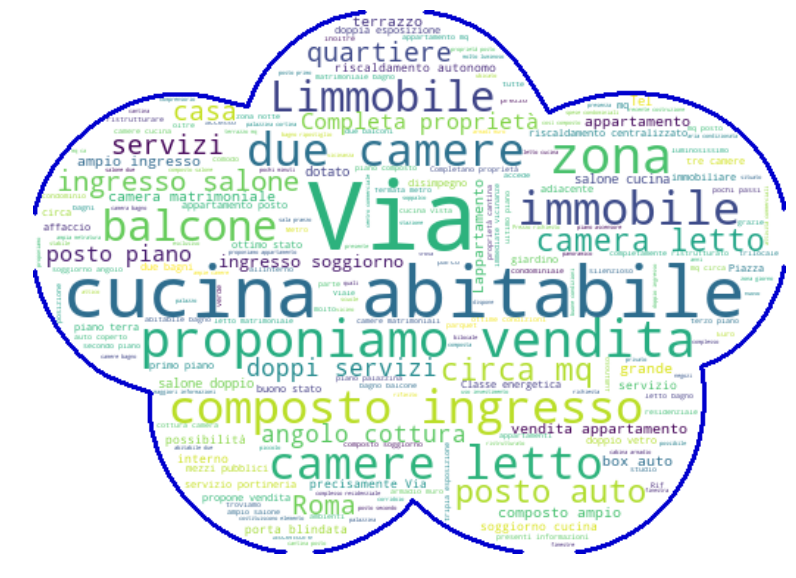

In [64]:
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud1, interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Second couple

In [65]:
c = set(d1[3])
d = set(d2[3])

intersect2 = list(c.intersection(d))

In [66]:
text2 = ''
for i in range(len(intersect2)):
    text2 = text2 + df.iloc[intersect2[i]]['Description']

In [67]:
text2 = strip_punctuation(text2)

In [69]:
wordcloud2 = WordCloud(mask=mask, background_color="white",max_words=1000, stopwords = stop, contour_width =3, contour_color='mediumblue').generate(
           text2)

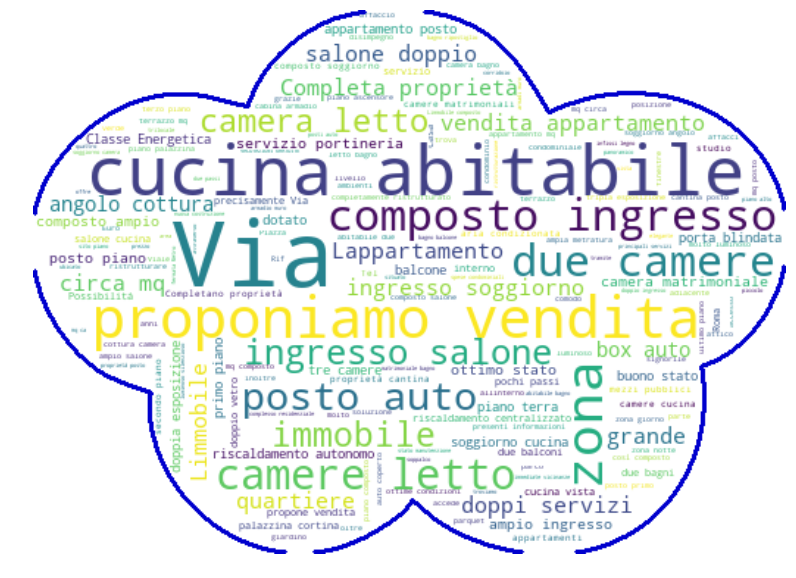

In [70]:
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

### Third couple

In [71]:
e = set(d1[2])
f = set(d2[3])

intersect3 = list(e.intersection(f))

In [72]:
text3 =''
for i in range(len(intersect3)):
    text3 = text3 + df.iloc[intersect3[i]]['Description']

In [73]:
text3 = strip_punctuation(text3)

In [76]:

wordcloud3 = WordCloud(mask=mask, background_color="white", max_words=1000, stopwords = stop, contour_width = 3, contour_color ='mediumblue').generate(
           text3)

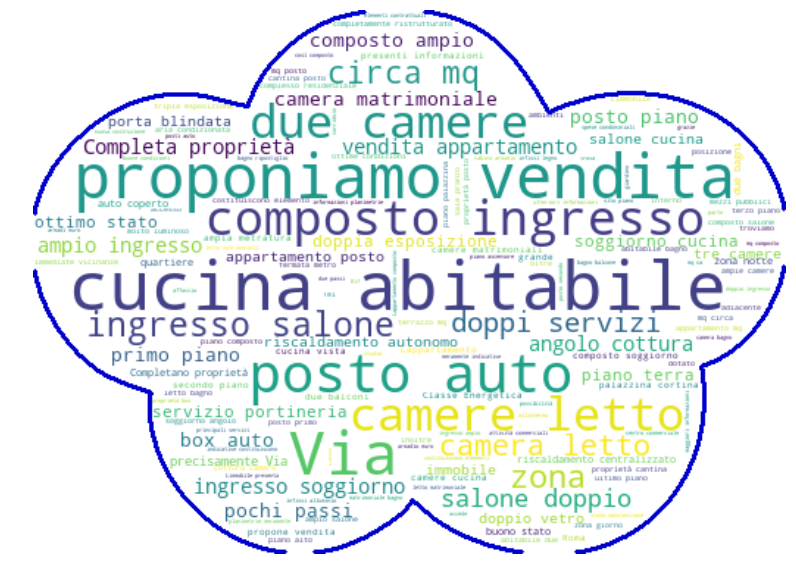

In [77]:
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

As we can see, we have quite frequent words, which are the ones that could be expected, for example: "via", "cucina" "abitabile", "camere", "letto", "proponiamo", "vendita", "camere", ad so on.
 
As conclusion, let's So the goal to make this wordclouds could be, help marketing of companies that sell homes on the internet, for example.
